[Папка](https://drive.google.com/drive/folders/1ifRQQG7T9FKXGw2gnX31d_88VbfcRQh5?usp=sharing) со всеми необходимыми данными.

Код обработки текстов библиотеками stanza, natasha, SpaCy, polyglot находится в самом конце (первый подпункт в пункте "Сравнение инструментов").
_________________________________
В пункте "Работа с таблицей с ответами" представлин код обработки выявленных ошибок.
_________________________________
В пункте "Лемматизация и нахождение микротопонимов Санкт-Петербурга" представлена работа с картотекой и последующим поисков топонимов по выборке.
_________________________________
В пункет "ML" производится работа с статистическими моделями.



## Работа с таблицей с ответами

In [ ]:
!pip install pymorphy2

In [ ]:
import re
from tqdm.auto import tqdm
from nltk.tokenize import word_tokenize
import pymorphy2
import nltk
from google.colab import drive
import pandas as pd


drive.mount('/content/drive')
nltk.download('punkt')
morph = pymorphy2.MorphAnalyzer()

In [3]:
with open('./drive/My Drive/course_work/stanza_with_answers.csv', encoding='utf-8', errors='ignore') as csvfile:
    stanza_df = pd.read_csv(csvfile, sep=';')

In [4]:
with open('./drive/My Drive/course_work/sentences.csv', encoding='utf-8', errors='ignore') as csvfile:
    sents_df = pd.read_csv(csvfile, sep='\t')

In [ ]:
sents_df.head(3)

,text,index,sentence
0,akhsharumov.kontsy_v_vodu.txt,1,Николай Дмитревич Ахшарумов
1,akhsharumov.kontsy_v_vodu.txt,2,Концы в воду
2,akhsharumov.kontsy_v_vodu.txt,3,Часть I


In [ ]:
stanza_df.head(3)

,index,text,entity,entries,is_place,is_sp,comments
0,1,akhsharumov.kontsy_v_vodu.txt,Р,"[512, 4098, 6, 3463, 6538, 1166, 1039, 3857, 1...",Y,N,пропуск части
1,2,akhsharumov.kontsy_v_vodu.txt,Москву,"[1185, 1250, 6, 3783, 1228, 110, 1343]",Y,N,NaN
2,3,akhsharumov.kontsy_v_vodu.txt,Спальных,[7],N,N,NaN


### Исправление ошибок

#### Список ошибок

In [16]:
mistakes = list(set(list(stanza_df['comments'])))
mistakes[1:]

['лишние цифры',
 'лишние знаки',
 'пропуск части',
 'несколько токенов',
 'лишние слова, лишние цифры',
 'лишние цифры, лишние знаки',
 'пропуск части, лишние цифры',
 'лишняя часть',
 'перенос',
 'перенос, пропуск части',
 'пропуск части, лишние слова',
 'лишние слова',
 'через дефис со след.',
 'словоерс',
 'однородные',
 'через дефис со след., пропуск части']

#### Лишние символы

In [ ]:
stanza_df['entity'] = stanza_df['entity'].str.replace('[^A-ZА-ЯЁa-zа-яё\- 0-9\*]','',regex=True)
stanza_df['entity'] = stanza_df['entity'].str.replace(' +',' ',regex=True)

#### Через дефис со след.

In [ ]:
indexes = stanza_df.index.copy()
ind_to_drop = []

for i in tqdm(range(len(indexes))):
  ent = stanza_df.loc[indexes[i], 'entity']
  ent_text = stanza_df.loc[indexes[i], 'text']
  ent_entry = stanza_df.loc[indexes[i], 'entries'].lstrip('[').rstrip(']').split(', ')[0]
  text_df = sents_df[sents_df['text']==ent_text]
  text = text_df[text_df['index']==int(ent_entry)]['sentence'].values[0]
  if '-' in text:
    sentence = re.sub (' +\- +', '\-', text)
    set_of_words = re.findall('[А-ЯёЁа-яA-Za-z]+\-[А-ЯёЁа-яA-Za-z]+[\-[А-ЯёЁа-яA-Za-z]+]*', sentence)
    new_ents = []
    for w in set_of_words:
      if ent in w and w != ent:
        new_ents.append(w)
    if new_ents:
      ind_to_drop.append(indexes[i])
      for e in new_ents:
        data = {col: [stanza_df.loc[indexes[i], col]] for col in list(stanza_df.columns)}
        data['index'] = [max(list(stanza_df['index']))+1]
        data['entity'] = [e]
        df = pd.DataFrame(data)
        stanza_df = stanza_df.append(df, ignore_index=True)
     

ind_to_drop = list(set(ind_to_drop))


  0%|          | 0/64445 [00:00<?, ?it/s]

In [ ]:
stanza_df.drop(index=ind_to_drop, inplace=True)

#### Лишняя часть (+ словоерс)

In [ ]:
end_particles = ['-де', '-ка', '-кое', '-кой', '-либо', '-нибудь', '-с', '-тка', '-тко', '-то', '-ка'] 

for part in end_particles:
  query = '\\' + part + '$'
  stanza_df['entity'] = stanza_df['entity'].str.replace(query,'',regex=True)

#### Перенос

In [ ]:
for i in tqdm(range(len(stanza_df))):
  ent = stanza_df.iloc[i, 2]
  if '-' in ent:
    clear_ent = re.sub('\-', '', ent)
    if clear_ent in list(stanza_df['entity']):
      stanza_df.iloc[i, 2] = clear_ent

  0%|          | 0/64453 [00:00<?, ?it/s]

#### Лишние цифры

In [ ]:
stanza_df['entity'] = stanza_df['entity'].str.replace(r'([^0-9])[0-9]+([^0-9])?',r'\g<1>\g<2>',regex=True)

#### Лишние слова

In [ ]:
import copy

In [ ]:
!pip install natasha

In [ ]:
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)


segmenter = Segmenter()
emb = NewsEmbedding()
ner_tagger = NewsNERTagger(emb)

In [ ]:
for i in tqdm(range(len(stanza_df.index))):
  ent_text = stanza_df.loc[stanza_df.index[i], 'text']
  ent_entry = stanza_df.loc[stanza_df.index[i], 'entries'].lstrip('[').rstrip(']').split(', ')[0]
  text_df = sents_df[sents_df['text']==ent_text]
  text = text_df[text_df['index']==int(ent_entry)]['sentence'].values[0]
  doc = Doc(text)
  doc.segment(segmenter)
  doc.tag_ner(ner_tagger)
  if len(doc.spans) > 0:
    for span in doc.spans:
      if span.type == 'LOC':
        natasha_entity = re.sub('[^a-zA-Zа-яА-ЯёЁ\-\*]', ' ', span.text)
        natasha_entity = re.sub(' +', ' ', natasha_entity)
        natasha_words = natasha_entity.split(' ')

        stanza_entity = re.sub('[^a-zA-Zа-яА-ЯёЁ\-\*]', ' ', stanza_df.iloc[i, 2])
        stanza_entity = re.sub(' +', ' ', stanza_entity)
        stanza_words = stanza_entity.split(' ')

        intersection = list(set(stanza_words) & set(natasha_words))
        if len(intersection) > 0:
          stanza_df.loc[stanza_df.index[i], 'entity'] = ' '.join(intersection)


  0%|          | 0/312 [00:00<?, ?it/s]

#### Несколько токенов

In [ ]:
preps = ['на', 'из', 'к', 'в', 'во', 'с', 'у']
conjs = ['и', 'да', 'или', 'аль', 'иль']
seps = preps+conjs

In [ ]:
indexes = stanza_df.index.copy()
ind_to_drop = []

for i in tqdm(range(len(indexes))):
  ent = stanza_df.loc[indexes[i], 'entity']
  ent = re.sub('[^a-zA-Zа-яА-ЯёЁ\-\*]', ' ', ent)
  ent = re.sub(' +', ' ', ent)
  if len(ent.split(' ')) > 1:
    ent = ' ' + ent
    for sep in seps:
      ent = re.sub(' '+sep+' ', '___', ent)
    e = ent.split('___')
    while '' in e:
      del e[e.index('')]
    if ent.lstrip(' ') != ' '.join(e).lstrip(' '):
      for en in e:
        en = en.lstrip(' ').rstrip(' ')
        data = {col: [stanza_df.loc[indexes[i], col]] for col in list(stanza_df.columns)}
        data['index'] = [int(max(list(stanza_df['index'])))+1]
        data['entity'] = [en]
        df = pd.DataFrame(data)

        stanza_df = stanza_df.append(df, ignore_index=True)
      ind_to_drop.append(indexes[i])

    

  0%|          | 0/64453 [00:00<?, ?it/s]

In [ ]:
stanza_df.drop(index=ind_to_drop, inplace=True)

In [ ]:
conv_poses = ['ADJF', 'ADJS', 'NOUN']
Y_entities = list(stanza_df[stanza_df['is_place']=='Y']['entity'])
indexes = stanza_df.index.copy()

In [ ]:
for i in tqdm(range(len(indexes))):
  ent = stanza_df.loc[indexes[i], 'entity'].split(' ')
  new_ent = []
  for w in ent:
    p = morph.parse(w)[0]
    if p.tag.POS not in conv_poses:
      if w in Y_entities:
        new_ent.append(w)
    else:
      new_ent.append(w)
  if not new_ent:
    if len(ent) != 1 and stanza_df.loc[indexes[i], 'is_place'] != 'Y':
      stanza_df = stanza_df.drop(index=[indexes[i]])
  else:
    stanza_df.loc[indexes[i], 'entity'] = ' '.join(new_ent)

  0%|          | 0/64577 [00:00<?, ?it/s]

In [ ]:
indexes = stanza_df.index.copy()
ind_to_drop = []

for i in tqdm(range(len(indexes))):
  ent = stanza_df.loc[indexes[i], 'entity']
  splitted_ent = []
  if len(ent.split(' ')) > 1:
    ent_text = stanza_df.loc[indexes[i], 'text']
    ent_entry = stanza_df.loc[indexes[i], 'entries'].lstrip('[').rstrip(']').split(', ')[0]
    text_df = sents_df[sents_df['text']==ent_text]
    text = text_df[text_df['index']==int(ent_entry)]['sentence'].values[0]
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_ner(ner_tagger)
    n_words = []
    if len(doc.spans) > 0:
      for span in doc.spans:
        if span.type == 'LOC':
          if span.text != ent:
            natasha_entity = re.sub('[^a-zA-Zа-яА-ЯёЁ\-\*]', ' ', span.text)
            natasha_entity = re.sub(' +', ' ', natasha_entity)
            n_words.append(natasha_entity)
    if len(n_words) > 0 and n_words[0] != ent:
      stanza_entity = re.sub('[^a-zA-Zа-яА-ЯёЁ\-\*]', ' ', ent)
      stanza_entity = re.sub(' +', ' ', stanza_entity).split(' ')
      nat_entity = ' '.join(n_words).split(' ')
      if set(nat_entity) == set(stanza_entity):
        for n in n_words:
          data = {col: [stanza_df.loc[indexes[i], col]] for col in list(stanza_df.columns)}
          data['index'] = [max(list(stanza_df['index']))+1]
          data['entity'] = [n]
          df = pd.DataFrame(data)
          stanza_df = stanza_df.append(df, ignore_index=True)
          ind_to_drop.append(indexes[i])

ind_to_drop = list(set(ind_to_drop))

  0%|          | 0/64494 [00:00<?, ?it/s]

In [ ]:
stanza_df.drop(index=ind_to_drop, inplace=True)

In [ ]:
stanza_df.drop(columns=['index'], inplace=True)

In [ ]:
stanza_df.drop_duplicates(inplace=True)

In [ ]:
stanza_df.to_csv('./drive/My Drive/course_work/half_clear_stanza_df_wo_inds.csv', sep=';', index=False)

## Лемматизация и нахождение микротопонимов Санкт-Петербурга

Определение топонимов Санкт-Петербурга

In [1]:
from google.colab import drive
import pandas as pd
from tqdm.auto import tqdm

drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
with open('./drive/My Drive/course_work/half_clear_stanza_df_wo_inds.csv', encoding='utf-8', errors='ignore') as csvfile:
    stanza_df = pd.read_csv(csvfile, sep=';')

In [17]:
all_entities = []

for i in range(1, 6):
  filename = './drive/My Drive/course_work/saint_p_entities/sp_streets'+str(i)+'.txt'

  with open(filename, encoding='utf-8', errors='ignore') as f:
    
    entities = f.read().split('\n')
    all_entities.extend(entities)

all_entities = list(set(all_entities))

In [ ]:
lemm_ents = []
for ent in all_entities:
  ent = re.sub('[^a-zа-яё\- ]', '', ent.lower())
  lemm_ent = []
  for e in ent.split(' '):
    p = morph.parse(e)[0].normal_form
    lemm_ent.append(p)
  lemm_ents.append(' '.join(lemm_ent))

In [ ]:
lemm_words = list(set(' '.join(lemm_ents).split(' ')))

In [ ]:
from nltk import word_tokenize 
from nltk.util import ngrams


text = ' '.join(lemm_ents)
token = word_tokenize(text)

In [ ]:
n_grams = []
for i in tqdm(range(2, 7)):
  grams = []
  gr = list(ngrams(token, i))
  for g in gr:
    grams.append(' '.join(g))
  n_grams.append(grams)

n_grams.insert(0, lemm_words)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
indexes = stanza_df.index.copy()
y_n_sp = []

for i in tqdm(range(len(indexes))):
  y_n = 'N'
  if stanza_df.loc[indexes[i], 'is_place'] == 'Y':
    ent = stanza_df.loc[indexes[i], 'entity']
    ent = re.sub('[^a-zа-яё\- ]', '', ent.lower())
    lemm_ent = []
    for e in ent.split(' '):
      p = morph.parse(e)[0].normal_form
      lemm_ent.append(p)
    lemmatized_ent = ' '.join(lemm_ent)
    for j in range(1, 7):
      if len(lemm_ent) == j:
        if lemmatized_ent in n_grams[j-1]:
          y_n = 'Y'
  y_n_sp.append(y_n)



  0%|          | 0/64473 [00:00<?, ?it/s]

In [ ]:
stanza_df['is_SP'] = y_n_sp

In [ ]:
stanza_df.drop(columns=['is_sp', 'comments'], inplace=True)
stanza_df.drop_duplicates(inplace=True)

In [ ]:
stanza_df.to_csv('./drive/My Drive/course_work/stanza_rez.csv', sep=';', index=False)

Посдчет топонимов Санкт-Петербурга

In [ ]:
indexes = stanza_df.index.copy()

lemm_sp_ents = []
actual_ents = {}

for i in tqdm(range(len(indexes))):
  if stanza_df.loc[indexes[i], 'is_SP'] == 'Y':
    ent = stanza_df.loc[indexes[i], 'entity']
    ent = re.sub('[^a-zа-яё\- ]', '', ent.lower())
    lemm_ent = []
    for e in ent.split(' '):
      p = morph.parse(e)[0].normal_form
      lemm_ent.append(p)
    lemm_sp_ents.append(' '.join(lemm_ent))
    if ' '.join(lemm_ent) in actual_ents.keys():
      if ent not in actual_ents[' '.join(lemm_ent)]:
        actual_ents[' '.join(lemm_ent)].append(ent)
    else:
      actual_ents[' '.join(lemm_ent)] = [ent]
    

  0%|          | 0/64454 [00:00<?, ?it/s]

In [ ]:
sp_df = pd.DataFrame({'lemma':actual_ents.keys(), 'all': list(actual_ents.values())})

In [ ]:
entr_c = []
for lemm in list(sp_df['lemma']):
  entr_c.append(len(sp_df[sp_df['lemma']==lemm]['all'].values[0].split(', ')))

sp_df['count'] = entr_c

sp_df.sort_values('count', ascending=False, inplace=True)



In [ ]:
with open('./drive/My Drive/course_work/stanza_rez_features.csv', encoding='utf-8', errors='ignore') as csvfile:
    stanza_df = pd.read_csv(csvfile, sep=';')

sp_stanza_df = stanza_df[stanza_df['is_SP']=='Y']
sp_stanza_df = sp_stanza_df[['text', 'entity', 'entries']]

In [ ]:
def count_entries(df):
  entries = list(df['entries'])
  c_entries = []
  for entry in entries:
    c_entry = len(entry.rstrip(']').lstrip('[').split(', '))
    c_entries.append(c_entry)
  return c_entries

In [ ]:
c_stanza = count_entries(sp_stanza_df)
sp_stanza_df['count_entries'] = c_stanza

In [ ]:
stanza_ent_count = {}
for text in list(set(list(sp_stanza_df['text']))):
  text_df = sp_stanza_df[sp_stanza_df['text']==text]
  for ent in list(text_df['entity']):
    low_ent = ent.lower()
    if low_ent not in stanza_ent_count.values():
      stanza_ent_count[low_ent] = text_df[text_df['entity']==ent]['count_entries'].values[0]
    else:
      stanza_ent_count[low_ent] += text_df[text_df['entity']==ent]['count_entries'].values[0]

In [ ]:
f_c = {}
for ent in list(sp_df['lemma']):
  words = sp_df[sp_df['lemma']==ent]['all'].values[0]
  words = re.sub('[\[\'\]]', '', words).split(', ')
  for word in words:
    if ent not in f_c.keys():
      f_c[ent] = stanza_ent_count[word]
    else:
      f_c[ent] += stanza_ent_count[word]

In [ ]:
df = pd.DataFrame({'ent': f_c.keys(), 'count': f_c.values()})
df.sort_values('count', ascending=False, inplace=True)

df.to_csv('sp_counter.csv', sep=';', index=False)

## ML

##### Фичи

In [ ]:
!pip install natasha
!pip install pymorphy2

In [43]:
import re
from tqdm.auto import tqdm
import pymorphy2
from google.colab import drive
import pandas as pd


drive.mount('/content/drive')
morph = pymorphy2.MorphAnalyzer()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)


segmenter = Segmenter()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)

In [45]:
with open('./drive/My Drive/course_work/sentences.csv', encoding='utf-8', errors='ignore') as csvfile:
    sents_df = pd.read_csv(csvfile, sep='\t')

In [21]:
with open('./drive/My Drive/course_work/stanza_rez.csv', encoding='utf-8', errors='ignore') as csvfile:
    stanza_df = pd.read_csv(csvfile, sep=';')

In [23]:
stanza_df[stanza_df['is_place']=='Y'].shape

(37591, 5)

In [ ]:
indexes = stanza_df.index.copy()

rels = []
pos_natasha = []
pos_pm2 = []
full_length = []
words_number = []
main_word_length = []
mean_length = []

for i in tqdm(range(len(indexes))):
  ent = stanza_df.loc[indexes[i], 'entity']
  splitted_ent = []
  ent_text = stanza_df.loc[indexes[i], 'text']
  ent_entry = stanza_df.loc[indexes[i], 'entries'].lstrip('[').rstrip(']').split(', ')[0]
  text_df = sents_df[sents_df['text']==ent_text]
  text = text_df[text_df['index']==int(ent_entry)]['sentence'].values[0]
  doc = Doc(text)
  doc.segment(segmenter)
  doc.tag_morph(morph_tagger)
  doc.parse_syntax(syntax_parser)
  ent_tokens = []
  for tok in doc.tokens:
    if tok.text in ent.split(' '):
      if tok.pos == 'NOUN':
        ent_tokens = [tok] + ent_tokens
      else:
        ent_tokens.append(tok)
  if ent_tokens:
    main_tok = ent_tokens[0]
  rels.append(main_tok.rel)
  pos_natasha.append(main_tok.pos)
  pos_pm2.append(morph.parse(main_tok.text)[0].tag.POS)
  main_word_length.append(len(main_tok.text))
  full_length.append(len(ent))
  mean_length.append(( len(ent) - (len(ent.split(' '))-1) )/ len(ent.split(' ')) )
  words_number.append(len(ent.split(' ')))


In [ ]:
print(rels[:5])
print(pos_natasha[:5])
print(pos_pm2[:5])
print(full_length[:5])
print(words_number[:5])
print(main_word_length[:5])
print(mean_length[:5])

['root', 'obl', 'obj', 'obl', 'obl']
['PROPN', 'PROPN', 'ADJ', 'PROPN', 'PROPN']
['NOUN', 'NOUN', 'ADJF', 'NOUN', 'NOUN']
[1, 6, 8, 9, 6]
[1, 1, 1, 1, 1]
[1, 6, 8, 9, 6]
[1.0, 6.0, 8.0, 9.0, 6.0]


In [ ]:
stanza_df['relation'] = rels
stanza_df['pos_natasha'] = pos_natasha
stanza_df['pos_pymorphy2'] = pos_pm2
stanza_df['length'] = full_length
stanza_df['words_number'] = words_number
stanza_df['main_word_length'] = main_word_length

In [ ]:
stanza_df.to_csv('/drive/My Drive/course_work/stanza_rez_features.csv', sep=';', index=False)

In [ ]:
with open('./drive/My Drive/course_work/stanza_rez_features.csv', encoding='utf-8', errors='ignore') as csvfile:
    stanza_df = pd.read_csv(csvfile, sep=';')

In [ ]:
indexes = stanza_df.index.copy()
YN_binar = {'Y': 1, 'N': 0, 'y': 1, 'n': 0}

for i in tqdm(range(len(indexes))):
  Y_N_place = stanza_df.loc[indexes[i], 'is_place']
  stanza_df.loc[indexes[i], 'is_place'] = YN_binar[Y_N_place]

  Y_N_SP = stanza_df.loc[indexes[i], 'is_SP']
  stanza_df.loc[indexes[i], 'is_SP'] = YN_binar[Y_N_SP]


  0%|          | 0/64454 [00:00<?, ?it/s]

In [ ]:
stanza_df.to_csv('./drive/My Drive/course_work/stanza_rez_features_bin.csv', sep=';', index=False)

##### Обучение

In [48]:
from google.colab import drive
import pandas as pd


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
with open('./drive/My Drive/course_work/stanza_rez_features_bin.csv', encoding='utf-8', errors='ignore') as csvfile:
    stanza_df = pd.read_csv(csvfile, sep=';')

In [50]:
import numpy as np 
from sklearn import tree
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report 

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)

In [51]:
df = stanza_df

In [52]:
df = df.fillna(method='ffill')

In [53]:
df.groupby('is_place').size().reset_index(name='counts')

,is_place,counts
0,0,26862
1,1,37592


In [54]:
X = df[['entity', 'relation', 'pos_natasha', 'pos_pymorphy2', 'length', 'words_number', 'main_word_length', 'mean_word_length']]
y = df[['is_place']]

classes = np.unique(y)
classes = classes.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=0)

X_train.shape, y_train.shape

((51563, 8), (51563, 1))

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


numeric_features = ['length', 'words_number', 'main_word_length', 'mean_word_length']
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_features = ['entity', 'relation', 'pos_natasha', 'pos_pymorphy2']
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


In [57]:
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, filename, labels, ymap=None, figsize=(10, 10)):
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap='rocket_r')
    plt.savefig(filename)

In [58]:
dtc = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", tree.DecisionTreeClassifier(random_state=0, max_depth=1000))]
)

result = dtc.fit(X_train, y_train)
pred = result.predict(X_test)

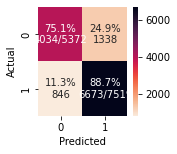

In [63]:
labels = dtc.classes_
cm_analysis(y_test, pred, 'cm_decisiontree_stanza.png', labels, figsize=(len(labels), len(labels)))

In [89]:
print(classification_report(y_pred=dtc.predict(X_test), y_true=y_test, labels=classes))

              precision    recall  f1-score   support

           0       0.83      0.75      0.79      5372
           1       0.83      0.89      0.86      7519

    accuracy                           0.83     12891
   macro avg       0.83      0.82      0.82     12891
weighted avg       0.83      0.83      0.83     12891



In [65]:
from sklearn import svm

In [66]:
svc_c = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", svm.SVC(decision_function_shape='ovo'))]
)

result = svc_c.fit(X_train, y_train)
pred = result.predict(X_test)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


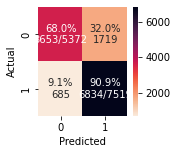

In [68]:
labels = svc_c.classes_
cm_analysis(y_test, pred, 'cm_svc_stanza.png', labels, figsize=(len(labels), len(labels)))

In [11]:
print(classification_report(y_pred=svc_c.predict(X_test), y_true=y_test, labels=classes))

              precision    recall  f1-score   support

           0       0.84      0.68      0.75      5372
           1       0.80      0.91      0.85      7519

    accuracy                           0.81     12891
   macro avg       0.82      0.79      0.80     12891
weighted avg       0.82      0.81      0.81     12891



In [69]:
from sklearn.linear_model import LogisticRegression

In [70]:
lr = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

result = lr.fit(X_train, y_train)
pred = result.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


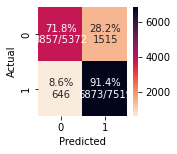

In [71]:
labels = lr.classes_
cm_analysis(y_test, pred, 'cm_svc_stanza.png', labels, figsize=(len(labels), len(labels)))

In [14]:
print(classification_report(y_pred=lr.predict(X_test), y_true=y_test, labels=classes))

              precision    recall  f1-score   support

           0       0.86      0.72      0.78      5372
           1       0.82      0.91      0.86      7519

    accuracy                           0.83     12891
   macro avg       0.84      0.82      0.82     12891
weighted avg       0.83      0.83      0.83     12891



## Сравнение инструментов

##### Обработка текстов

In [ ]:
!pip install prereform2modern

In [ ]:
from os import listdir, remove
from prereform2modern import Processor
from tqdm.auto import tqdm

In [ ]:
files = listdir('lit')

for file in files:
    if '.old.txt' in file:
        new_name = file.split('.')
        del new_name[-2]
        new_name = '.'.join(new_name)
        with open('lit/'+file, 'r', encoding='utf-8') as f:
            orig_text = f.read()
            text_res, changes, s_json = Processor.process_text(
                text=orig_text,
                show=False,
                delimiters=False,
                check_brackets=False
                )
            with open('lit/'+new_name, 'w', encoding='utf-8') as f_to_write:
                f_to_write.write(text_res)
        remove('lit/'+file)

In [ ]:
files = listdir('lit')
sp_count = []
for i in tqdm(range(len(files))):
    with open('lit/'+files[i], 'r', encoding='utf-8') as f:
        words = f.read().split(' ')
        n = 0
        for word in words:
            if 'петербур' in word.lower() or 'ленинград' in word.lower():
                n+=1
        if n != 0:
            sp_count.append((files[i], n))

In [ ]:
for narrative in sp_count:
    with open('lit/'+narrative[0], 'r', encoding='utf-8') as file:
        text = file.read()
        with open('lit/saint_p/'+narrative[0], 'w', encoding='utf-8') as f2write:
            f2write.write(text)

##### Поиск сущностей с помощью *библиотек*

In [ ]:
from tqdm.auto import tqdm
from google.colab import drive
import csv
import pandas as pd
from statistics import mean


drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
with open('./drive/My Drive/course_work/sentences.csv', encoding='utf-8', errors='ignore') as csvfile:
    sents_df = pd.read_csv(csvfile, sep='\t')

In [4]:
texts = list(set(list(stanza_sents_df['text'])))

In [7]:
lengths = []
for text in texts:
  lengths.append(len(sents_df[sents_df['text']==text]['sentence']))

In [10]:
print(max(lengths), min(lengths), mean(lengths))

30657 355 4822.105651105651


In [ ]:
def save_results(ents, mod):
    with open('./drive/My Drive/course_work/course_results_' + mod + '.csv', 'a', encoding='utf-8') as csv_file:
        file_writer = csv.writer(csv_file, delimiter = '\t')
        file_writer.writerow(['text', 'entity', 'entries'])
        for text_ent in ents:
            all_ents = text_ent[list(text_ent)[0]]
            for one_ent in list(all_ents):
                file_writer.writerow([list(text_ent)[0], one_ent, list(set(all_ents[one_ent]))])

In [ ]:
!pip install polyglot
!pip install pyicu
!pip install pycld2
!pip install morfessor

In [ ]:
import polyglot
from polyglot.text import Text

!polyglot download embeddings2.ru ner2.ru

In [ ]:
def find_with_polyglot(texts): 
    all_texts_ents = []
    for i in tqdm(range(len(texts))):
        al = {}
        text_df = stanza_sents_df[stanza_sents_df['text'] == texts[i]]
        inds = list(text_df['index'])
        for j in inds:
            txt = text_df[text_df['index']==j]['sentence'].values[0]
            text = Text(txt)
            text.hint_language_code = 'ru'
            entities = text.entities
            for ent in entities:
                if ent.tag == 'I-LOC':
                    try:
                        if j not in al[ent[0]]:
                            al[ent[0]].append(j)
                    except:
                        al[ent[0]] = [j]
        all_texts_ents.append({texts[i]: al})
    return all_texts_ents

In [ ]:
polyglot_results = find_with_polyglot(texts)
save_results(polyglot_results, 'polyglot')

  0%|          | 0/407 [00:00<?, ?it/s]

In [ ]:
!pip install spacy

In [ ]:
def find_with_spacy(texts):
    all_texts_ents = []
    nlp = spacy.load('ru_core_news_lg')
    for i in tqdm(range(len(texts))):
        text_df = stanza_sents_df[stanza_sents_df['text'] == texts[i]]
        inds = list(text_df['index'])
        al = {}
        for j in inds:
            txt = text_df[text_df['index']==j]['sentence'].values[0]
            entities = nlp(txt).ents
            for ent in entities:
                if ent.label_ == 'LOC':
                    s = re.sub('\t', ' ', ent.text.strip())
                    s = re.sub('\n', ' ', s)
                    s = re.sub('[!\?\*\{\}\[\]\`\®\^\…\'\"]', ' ', s)
                    s = re.sub(' +', ' ', s)
                    if s[0] == ' ':
                        s = s.lstrip(' ')
                    if s[-1] == ' ':
                        s = s.rstrip(' ')
                    try:
                        if j not in al[s]:
                            al[s].append(j)
                    except:
                        al[s] = [j]
        all_texts_ents.append({texts[i]: al})
    return all_texts_ents


In [ ]:
spacy_results = find_with_spacy(texts)
save_results(spacy_results, 'spacy')

In [ ]:
!pip install natasha

In [ ]:
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,

    Doc
)
emb = NewsEmbedding()
segmenter = Segmenter()
ner_tagger = NewsNERTagger(emb)


In [ ]:
def find_with_natasha(texts): 
    all_texts_ents = []
    for i in tqdm(range(len(texts))):
        al = {}
        text_df = stanza_sents_df[stanza_sents_df['text'] == texts[i]]
        inds = list(text_df['index'])
        for j in inds:
            txt = text_df[text_df['index']==j]['sentence'].values[0]
            doc = Doc(txt)
            doc.segment(segmenter)
            doc.tag_ner(ner_tagger)
            entities = doc.spans
            for ent in entities:
                if ent.type == 'LOC':
                    try:
                        if j not in al[ent.text]:
                            al[ent.text].append(j)
                    except:
                        al[ent.text] = [j]
        all_texts_ents.append({texts[i]: al})
    return all_texts_ents

In [ ]:
natasha_results = find_with_natasha(texts)
save_results(natasha_results, 'natasha')

  0%|          | 0/407 [00:00<?, ?it/s]

In [ ]:
!pip install stanza

In [ ]:
import stanza
stanza.download('ru')

In [ ]:
def find_with_stanza(files): 
    all_texts_ents = []
    nlp = stanza.Pipeline(lang='ru', processors='tokenize,ner')
    for i in tqdm(range(len(texts))):
        al = {}
        text_df = stanza_sents_df[stanza_sents_df['text'] == texts[i]]
        inds = list(text_df['index'])
        for j in inds:
            txt = text_df[text_df['index']==j]['sentence'].values[0]
            doc = nlp(txt)
            nrrtv_text = doc.sentences
            al = {}
            for j in range(len(nrrtv_text)):
                for ent in nrrtv_text[j].ents:
                    if ent.type == 'LOC':
                        s = re.sub('\t', ' ', ent.text)
                        s = re.sub('\n', ' ', s)
                        s = re.sub('[!\?\*\{\}\[\]\`\®\^\…\'\"]', ' ', s)
                        s = re.sub(' +', ' ', s)
                        if s[0] == ' ':
                            s = s.lstrip(' ')
                        if s[-1] == ' ':
                            s = s.rstrip(' ')
                        try:
                            if j+1 not in al[s]:
                                al[s].append(j+1)
                        except:
                            al[s] = [j+1]
            all_texts_ents.append({texts[i]: al})
    return all_texts_ents

In [ ]:
stanza_results = find_with_stanza(texts)
save_results(stanza_results, 'stanza')

##### Сравнение работы библиотек

In [1]:
from tqdm.auto import tqdm
from google.colab import drive
import pandas as pd
import re


drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
with open('./drive/My Drive/course_work/stanza_rez_features.csv', encoding='utf-8', errors='ignore') as csvfile:
  stanza_df_first = pd.read_csv(csvfile, sep=';')

In [48]:
with open('./drive/My Drive/course_work/course_results_natasha.csv', encoding='utf-8', errors='ignore') as csvfile:
  natasha_df = pd.read_csv(csvfile, sep='\t')
with open('./drive/My Drive/course_work/stanza_rez.csv', encoding='utf-8', errors='ignore') as csvfile:
  stanza_df = pd.read_csv(csvfile, sep=';')
with open('./drive/My Drive/course_work/course_results_spacy.csv', encoding='utf-8', errors='ignore') as csvfile:
  spacy_df = pd.read_csv(csvfile, sep='\t')
with open('./drive/My Drive/course_work/course_results_polyglot.csv', encoding='utf-8', errors='ignore') as csvfile:
  polyglot_df = pd.read_csv(csvfile, sep='\t')

In [39]:
def count_entries(df):
  entries = list(df['entries'])
  c_entries = []
  for entry in entries:
    c_entry = len(entry.rstrip(']').lstrip('[').split(', '))
    c_entries.append(c_entry)
  return c_entries

In [40]:
c_stanza_first = count_entries(stanza_df_first)
stanza_df_first['count_entries'] = c_stanza_first

In [ ]:
c_polyglot = count_entries(polyglot_df)
polyglot_df['count_entries'] = c_polyglot

c_spacy = count_entries(spacy_df)
spacy_df['count_entries'] = c_spacy

c_natasha = count_entries(natasha_df)
natasha_df['count_entries'] = c_natasha

c_stanza = count_entries(stanza_df)
stanza_df['count_entries'] = c_stanza

In [51]:
texts = list(set(list(stanza_df['text'])))

In [43]:
def clear_ents(df):
  clear = []
  for ent in list(df['entity']):
    ent = re.sub('[\n\t]+', ' ', ent)
    ent = re.sub('[^a-zA-Zа-яёА-ЯЁ\- ]+', ' ', ent)
    ent = re.sub(' +', ' ', ent)
    clear.append(ent)
  return clear

In [52]:
stanza_df_first['clear_entity'] = clear_ents(stanza_df_first)

In [ ]:
polyglot_df['clear_entity'] = clear_ents(polyglot_df)

spacy_df['clear_entity'] = clear_ents(spacy_df)

natasha_df['clear_entity'] = clear_ents(natasha_df)

In [45]:
def compare_df(stanza_df, df, texts):
  y_n_df = []
  stanza_c = []
  y_n_sp = []
  missing = {}
  for text in texts:
    text_df = df[df['text']==text]

    stanza_text_df = stanza_df[stanza_df['text']==text]
    text_ents_stanza = list(stanza_text_df[stanza_text_df['is_place']=='Y']['entity'])
    text_ents_df = list(text_df['clear_entity'])

    for s_ent in text_ents_stanza:
      if s_ent not in text_ents_df:
        if s_ent not in missing.values():
          missing[s_ent] = stanza_text_df[stanza_text_df['entity'] == s_ent]['count_entries'].values[0]
        else:
          missing[s_ent] += stanza_text_df[stanza_text_df['entity'] == s_ent]['count_entries'].values[0]

    for ent in list(text_df['clear_entity']):
      if ent not in text_ents_stanza:
        stanza_c.append(0)
        y_n_df.append('N')
        y_n_sp.append('N')
      else:
        stanza_c.append(stanza_text_df[stanza_text_df['entity']==ent]['count_entries'].values[0])
        y_n_df.append(stanza_text_df[stanza_text_df['entity']==ent]['is_place'].values[0])
        y_n_sp.append(stanza_text_df[stanza_text_df['entity']==ent]['is_SP'].values[0])
    
  return stanza_c, y_n_df, y_n_sp, missing

In [53]:
stanza_df_first['stanza_count'], stanza_df_first['is_place'], stanza_df_first['is_SP'], missing_in_stanza_first = compare_df(stanza_df, stanza_df_first, texts)


In [ ]:
polyglot_df['stanza_count'], polyglot_df['is_place'], polyglot_df['is_SP'], missing_in_polyglot = compare_df(stanza_df, polyglot_df, texts)

spacy_df['stanza_count'], spacy_df['is_place'], spacy_df['is_SP'], missing_in_spacy = compare_df(stanza_df, spacy_df, texts)

natasha_df['stanza_count'], natasha_df['is_place'], natasha_df['is_SP'], missing_in_natasha = compare_df(stanza_df, natasha_df, texts)

In [56]:
print('stanza (первоначальный датасет)\nВсего уникальных сущностей:', len(missing_in_stanza_first), '\nВ сумме не угадано:', sum(list(missing_in_stanza_first.values())))

stanza (первоначальный датасет)
Всего уникальных сущностей: 3 
В сумме не угадано: 4


In [ ]:
print('polyglot\nВсего уникальных сущностей:', len(missing_in_polyglot), '\nВ сумме не угадано:', sum(list(missing_in_polyglot.values())))
print('\nspacy\nВсего уникальных сущностей:', len(missing_in_spacy), '\nВ сумме не угадано:', sum(list(missing_in_spacy.values())))
print('\nnatasha\nВсего уникальных сущностей:', len(missing_in_natasha), '\nВ сумме не угадано:', sum(list(missing_in_natasha.values())))

polyglot
Всего уникальных сущностей: 12611 
В сумме не угадано: 18125

spacy
Всего уникальных сущностей: 6268 
В сумме не угадано: 7912

natasha
Всего уникальных сущностей: 6103 
В сумме не угадано: 7600


In [ ]:
polyglot_df['lib_difference'] = polyglot_df['stanza_count'] - polyglot_df['count_entries']
spacy_df['lib_difference'] = spacy_df['stanza_count'] - spacy_df['count_entries']
natasha_df['lib_difference'] = natasha_df['stanza_count'] - natasha_df['count_entries']

In [55]:
stanza_df_first['lib_difference'] = stanza_df_first['stanza_count'] - stanza_df_first['count_entries']

In [58]:
stanza_right = sum(list(stanza_df[stanza_df['is_place']=='Y']['count_entries']))
stanza_guessed = sum(list(stanza_df['count_entries']))

In [59]:
print('Точность stanza (первоначальный датасет):')
sf_guessed_right = sum(list(stanza_df_first[stanza_df_first['is_place']=='Y']['count_entries']))
sf_guessed = sum(list(stanza_df_first['count_entries']))
sf_not_guessed = sum(list(missing_in_stanza_first.values()))
sf_partly_not_guessed = sum(list(stanza_df_first[stanza_df_first['is_place']=='Y']['lib_difference']))

print(sf_guessed_right/(sf_guessed+sf_not_guessed+sf_partly_not_guessed))

print('\nПолнота stanza (первоначальный датасет):')

print(sf_guessed_right/stanza_right)


Точность stanza (первоначальный датасет):
0.505895087535082

Полнота stanza (первоначальный датасет):
0.809336665387766


In [60]:
print('Точность stanza (первоначальный датасет) (если учитывать только уникальные вхождения):')
sf_guessed_right = len(list(stanza_df_first[stanza_df_first['is_place']=='Y']['count_entries']))
sf_guessed = len(list(stanza_df_first['count_entries']))
sf_not_guessed = len(list(missing_in_stanza_first.values()))
sf_partly_not_guessed = len(list(stanza_df_first[stanza_df_first['is_place']=='Y']['lib_difference']))

print(sf_guessed_right/(sf_guessed+sf_not_guessed+sf_partly_not_guessed))

print('\nПолнота stanza (первоначальный датасет) (если учитывать только уникальные вхождения):')

print(sf_guessed_right/len(list(stanza_df[stanza_df['is_place']=='Y']['count_entries'])))

Точность stanza (первоначальный датасет) (если учитывать только уникальные вхождения):
0.36839062438756714

Полнота stanza (первоначальный датасет) (если учитывать только уникальные вхождения):
1.000106408448831


In [ ]:
print('Точность polyglot:')
p_guessed_right = sum(list(polyglot_df[polyglot_df['is_place']=='Y']['count_entries']))
p_guessed = sum(list(polyglot_df['count_entries']))
p_not_guessed = sum(list(missing_in_polyglot.values()))
p_partly_not_guessed = sum(list(polyglot_df[polyglot_df['is_place']=='Y']['lib_difference']))

print(p_guessed_right/(p_guessed+p_not_guessed+p_partly_not_guessed))

print('\nПолнота polyglot:')

print(p_guessed_right/stanza_right)


Точность polyglot:
0.10619528240091844

Полнота polyglot:
0.31269118699254433


In [ ]:
print('Точность polyglot (если учитывать только уникальные вхождения):')
p_guessed_right = len(list(polyglot_df[polyglot_df['is_place']=='Y']['count_entries']))
p_guessed = len(list(polyglot_df['count_entries']))
p_not_guessed = len(list(missing_in_polyglot.values()))
p_partly_not_guessed = len(list(polyglot_df[polyglot_df['is_place']=='Y']['lib_difference']))

print(p_guessed_right/(p_guessed+p_not_guessed+p_partly_not_guessed))

print('\nПолнота polyglot (если учитывать только уникальные вхождения):')

print(p_guessed_right/len(list(stanza_df[stanza_df['is_place']=='Y']['count_entries'])))

Точность polyglot (если учитывать только уникальные вхождения):
0.1101791598416816

Полнота polyglot (если учитывать только уникальные вхождения):
0.45987071373467053


In [ ]:
print('Точность natasha:')
n_guessed_right = sum(list(natasha_df[natasha_df['is_place']=='Y']['count_entries']))
n_guessed = sum(list(natasha_df['count_entries']))
n_not_guessed = sum(list(missing_in_natasha.values()))
n_partly_not_guessed = sum(list(natasha_df[natasha_df['is_place']=='Y']['lib_difference']))

print(n_guessed_right/(n_guessed+n_not_guessed+n_partly_not_guessed))

print('\nПолнота natasha:')

print(n_guessed_right/stanza_right)

Точность natasha:
0.4618115579684263

Полнота natasha:
0.6703754782915271


In [ ]:
print('Точность natasha (если учитывать только уникальные вхождения):')
n_guessed_right = len(list(natasha_df[natasha_df['is_place']=='Y']['count_entries']))
n_guessed = len(list(natasha_df['count_entries']))
n_not_guessed = len(list(missing_in_natasha.values()))
n_partly_not_guessed = len(list(natasha_df[natasha_df['is_place']=='Y']['lib_difference']))

print(n_guessed_right/(n_guessed+n_not_guessed+n_partly_not_guessed))

print('\nПолнота natasha (если учитывать только уникальные вхождения):')

print(n_guessed_right/len(list(stanza_df[stanza_df['is_place']=='Y']['count_entries'])))

Точность natasha (если учитывать только уникальные вхождения):
0.34230742611945464

Полнота natasha (если учитывать только уникальные вхождения):
0.7894442818759809


In [ ]:
print('Точность spacy:')
s_guessed_right = sum(list(spacy_df[spacy_df['is_place']=='Y']['count_entries']))
s_guessed = sum(list(spacy_df['count_entries']))
s_not_guessed = sum(list(missing_in_spacy.values()))
s_partly_not_guessed = sum(list(spacy_df[spacy_df['is_place']=='Y']['lib_difference']))

print(s_guessed_right/(s_guessed+s_not_guessed+s_partly_not_guessed))

print('\nПолнота spacy:')

print(s_guessed_right/stanza_right)

Точность spacy:
0.38202122613907247

Полнота spacy:
0.6431141574292025


In [ ]:
print('Точность spacy (если учитывать только уникальные вхождения):')
s_guessed_right = len(list(spacy_df[spacy_df['is_place']=='Y']['count_entries']))
s_guessed = len(list(spacy_df['count_entries']))
s_not_guessed = len(list(missing_in_spacy.values()))
s_partly_not_guessed = len(list(spacy_df[spacy_df['is_place']=='Y']['lib_difference']))

print(s_guessed_right/(s_guessed+s_not_guessed+s_partly_not_guessed))

print('\nПолнота spacy (если учитывать только уникальные вхождения):')

print(s_guessed_right/len(list(stanza_df[stanza_df['is_place']=='Y']['count_entries'])))

Точность spacy (если учитывать только уникальные вхождения):
0.2993329742718648

Полнота spacy (если учитывать только уникальные вхождения):
0.7688010428027986


In [ ]:
print('Точночть stanza:')

print(stanza_right/stanza_guessed)

Точночть stanza:
0.7237135374062873


In [ ]:
print('Точночть stanza (если учитывать только уникальные вхождения):')

print(len(list(stanza_df[stanza_df['is_place']=='Y']['count_entries']))/len(list(stanza_df['count_entries'])))

Точночть stanza (если учитывать только уникальные вхождения):
0.5832221429236355


In [ ]:
polyglot_df.to_csv('./drive/My Drive/course_work/polyglot_rez_final.csv', sep=';', index=False)
spacy_df.to_csv('./drive/My Drive/course_work/spacy_rez_final.csv', sep=';', index=False)
natasha_df.to_csv('./drive/My Drive/course_work/natasha_rez_final.csv', sep=';', index=False)